In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import uproot
import awkward as ak
import sys

%matplotlib inline

In [43]:
#data_path = "/dipc/elena/WCTE_2025_commissioning/root_files/data/260MeVc/WCTE_offline_R1574S0_VME1558.root"  #260MeV/c  44 pion-only events

data_path = "/dipc/elena/WCTE_2025_commissioning/root_files/data/WCTE_offline_R1711S0_VME1650.root"   #260MeV/c, 52 pion-only events
                                                                                                    # ~8500 e-only events
#mc_path = "/dipc/elena/WCTE_2025_commissioning/root_files/mc/pi+_260MeVc_1000evts_masked.root"
mc_path = "/scratch/elena/WCTE_DATA_ANALYSIS/WCTE-DataAnalysis-PIDcuts/wcte_run/test/mu-_260MeVc_3000evts_1_masked.root"


tree ="WCTEReadoutWindows"
n_events = 3000

data_tree = uproot.open(f"{data_path}:{tree}")
mc_tree = uproot.open(f"{mc_path}:{tree}")


data = data_tree.arrays(entry_stop = n_events, library="ak")
mc = mc_tree.arrays(entry_stop = n_events, library="ak")

In [44]:
import numpy as np

unique_triggers = np.unique(mc["trigger_types"])
print(unique_triggers)

[0]


In [45]:
print(f"Data events loaded: {len(data['event_number'])}")  
print(f"MC events loaded: {len(mc['event_number'])}")

Data events loaded: 3000
MC events loaded: 3000


In [46]:
for branch in (data.fields):
    print(branch, ak.type(data[branch]))  #if "var", variable number of elements

window_time 3000 * float64
run_id 3000 * int32
sub_run_id 3000 * int32
spill_counter 3000 * int32
event_number 3000 * int32
readout_number 3000 * int32
trigger_types 3000 * var * int32
trigger_times 3000 * var * float64
led_gains 3000 * var * float32
led_dacsettings 3000 * var * float32
led_ids 3000 * var * int32
led_card_ids 3000 * var * int32
led_slot_numbers 3000 * var * int32
led_event_types 3000 * var * int32
led_types 3000 * var * int32
led_sequence_numbers 3000 * var * int32
led_counters 3000 * var * int32
hit_mpmt_card_ids 3000 * var * int32
hit_pmt_channel_ids 3000 * var * int32
hit_mpmt_slot_ids 3000 * var * int32
hit_pmt_position_ids 3000 * var * int32
hit_pmt_charges 3000 * var * float32
hit_pmt_times 3000 * var * float64
pmt_waveform_mpmt_card_ids 3000 * var * int32
pmt_waveform_pmt_channel_ids 3000 * var * int32
pmt_waveform_mpmt_slot_ids 3000 * var * int32
pmt_waveform_pmt_position_ids 3000 * var * int32
pmt_waveform_times 3000 * var * float64
pmt_waveforms 3000 * var * 

In [47]:
import sys
sys.path.append("/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_2025_commissioning/2025_data/")
import DataQualityNotebooks.VMEAnalysis as VMEAnalysisModule
import importlib
importlib.reload(VMEAnalysisModule) 
from DataQualityNotebooks.VMEAnalysis import VMEAnalysis


config_file = "/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_2025_commissioning/config/lep_v51_config.json"
vme_analysis_cut = {
    "t4_qcut": 300,
    "hc0_cut": 150,
    "hc1_cut": 100,
    "act1_ev": 900,
    "act2_pi": 1800,
    "act2_mu_low": 2000,
    "act2_mu_high": 10000,
    "tdc_cut": 200
}

#extract the interesting variables
qdc_charges = data["beamline_pmt_qdc_charges"]
qdc_ids = data["beamline_pmt_qdc_ids"]
tdc_times = data["beamline_pmt_tdc_times"]
tdc_ids = data["beamline_pmt_tdc_ids"]

#initialize the VMEAnalysis object
vme = VMEAnalysis(config_file, vme_analysis_cut, runNumber=1711)

#load data into the analysis object
q, tdc = vme.load_data(qdc_ids, qdc_charges, tdc_ids, tdc_times)

#apply cuts (mask)
vme.make_cuts_on_data(qdc_ids, qdc_charges, tdc_ids, tdc_times)

#mask for e-only
mu_mask = vme.getEventMask("muon-only")

#apply mask to the awkward array to filter events
data = data[mu_mask]

print(f"Selected {len(data)} muon-like events")     #out of {len(df_data)} total events")

Current Working Directory: /scratch/elena/WCTE_DATA_ANALYSIS
[INFO] Total events: 3000
[INFO] Computing activity sums and TOF values...
[INFO] Applying additional cuts...
[INFO] Defining cut sequences...
[INFO] Converting to NumPy for stats...
[INFO] Gathering statistics per cut set...
Selected 374 muon-like events


# let's explore the waverforms of Data

In [48]:
for branch in (data.fields):
    if "waveform" in branch.lower():
        print(branch, ak.type(data[branch]))  #if "var", variable number of elements

pmt_waveform_mpmt_card_ids 374 * var * int32
pmt_waveform_pmt_channel_ids 374 * var * int32
pmt_waveform_mpmt_slot_ids 374 * var * int32
pmt_waveform_pmt_position_ids 374 * var * int32
pmt_waveform_times 374 * var * float64
pmt_waveforms 374 * var * var * float64


In [49]:
data_wave = ak.flatten(data["pmt_waveforms"])
print(data_wave)

[[-2, -1, -1, -1, -1, 0, 10, 40, 55, 21, -13, ... 1, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0]]


In [50]:
print(data["pmt_waveform_mpmt_card_ids"][0])  # card ids for event 0
print(data["pmt_waveform_pmt_channel_ids"][0])
print(data["pmt_waveform_mpmt_slot_ids"][0])
print(data["pmt_waveform_pmt_position_ids"][0])
print(data["pmt_waveform_times"][0])
print(data["pmt_waveforms"][0])

[25, 25, 25, 25, 25, 34, 10, 17, 132, ... 130, 130, 130, 130, 130, 130, 130, 130]
[0, 1, 7, 12, 17, 17, 11, 8, 17, 18, 6, ... 7, 9, 10, 19, 15, 16, 13, 14, 15, 1, 15]
[62, 62, 62, 62, 62, 78, 61, 29, -1, -1, ... -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[17, 6, 2, 4, 15, 15, 11, 9, -2, -2, -2, ... -2, -2, -2, -2, -2, -2, -2, -2, -2, -2]
[2.62e+03, 2.62e+03, 2.62e+03, 2.62e+03, ... 4.02e+03, 4.18e+03, 5.31e+03, 6.31e+03]
[[-2, -1, -1, -1, -1, 0, 10, 40, 55, 21, -13, ... 1, 2, 1, 1, 0, 0, 1, 1, 0, 1, 1]]


In [51]:
event_index = 0

card_ids = data["pmt_waveform_mpmt_card_ids"][event_index]
slot_ids = data["pmt_waveform_mpmt_slot_ids"][event_index]
channel_ids = data["pmt_waveform_pmt_channel_ids"][event_index]
position_ids = data["pmt_waveform_pmt_position_ids"][event_index]
times = data["pmt_waveform_times"][event_index]
waveforms = data["pmt_waveforms"][event_index]

#mask to discard card_id > 120 and slot_id = -1
mask = [(c < 120) and (s != -1) for c, s in zip(card_ids, slot_ids)]

#apply mask to filter all arrays
filtered_card_ids = [c for c, keep in zip(card_ids, mask) if keep]
filtered_slot_ids = [s for s, keep in zip(slot_ids, mask) if keep]
filtered_channel_ids = [ch for ch, keep in zip(channel_ids, mask) if keep]
filtered_position_ids = [p for p, keep in zip(position_ids, mask) if keep]
filtered_times = [t for t, keep in zip(times, mask) if keep]
filtered_waveforms = [wf for wf, keep in zip(waveforms, mask) if keep]

print("Original number of waveforms:", len(card_ids))
print("Filtered number of waveforms:", len(filtered_card_ids))

Original number of waveforms: 412
Filtered number of waveforms: 381


In [52]:
original_waves = []
filtered_waves = []

#containers to store filtered data
filtered_data = {
    "card_ids": [],
    "slot_ids": [],
    "channel_ids": [],
    "position_ids": [],
    "times": [],
    "waveforms": []
}

for event_index in range(len(data)):
    card_ids = data["pmt_waveform_mpmt_card_ids"][event_index]
    slot_ids = data["pmt_waveform_mpmt_slot_ids"][event_index]
    channel_ids = data["pmt_waveform_pmt_channel_ids"][event_index]
    position_ids = data["pmt_waveform_pmt_position_ids"][event_index]
    times = data["pmt_waveform_times"][event_index]
    waveforms = data["pmt_waveforms"][event_index]
    
    original_waves.append(len(card_ids))
    

    mask = [(c < 120) and (s != -1) for c, s in zip(card_ids, slot_ids)]
    

    filtered_waves.append(sum(mask))
    
 
    filtered_data["card_ids"].append([c for c, keep in zip(card_ids, mask) if keep])
    filtered_data["slot_ids"].append([s for s, keep in zip(slot_ids, mask) if keep])
    filtered_data["channel_ids"].append([ch for ch, keep in zip(channel_ids, mask) if keep])
    filtered_data["position_ids"].append([p for p, keep in zip(position_ids, mask) if keep])
    filtered_data["times"].append([t for t, keep in zip(times, mask) if keep])
    filtered_data["waveforms"].append([wf for wf, keep in zip(waveforms, mask) if keep])


#df to display the filtering 
df_waves = pd.DataFrame({
    "original_waveforms": original_waves,
    "filtered_waveforms": filtered_waves
})

print(df_waves)

     original_waveforms  filtered_waveforms
0                   412                 381
1                   316                 286
2                   494                 463
3                   200                 171
4                   378                 341
..                  ...                 ...
369                1251                1148
370                 307                 275
371                 676                 646
372                 367                 342
373                 496                 469

[374 rows x 2 columns]


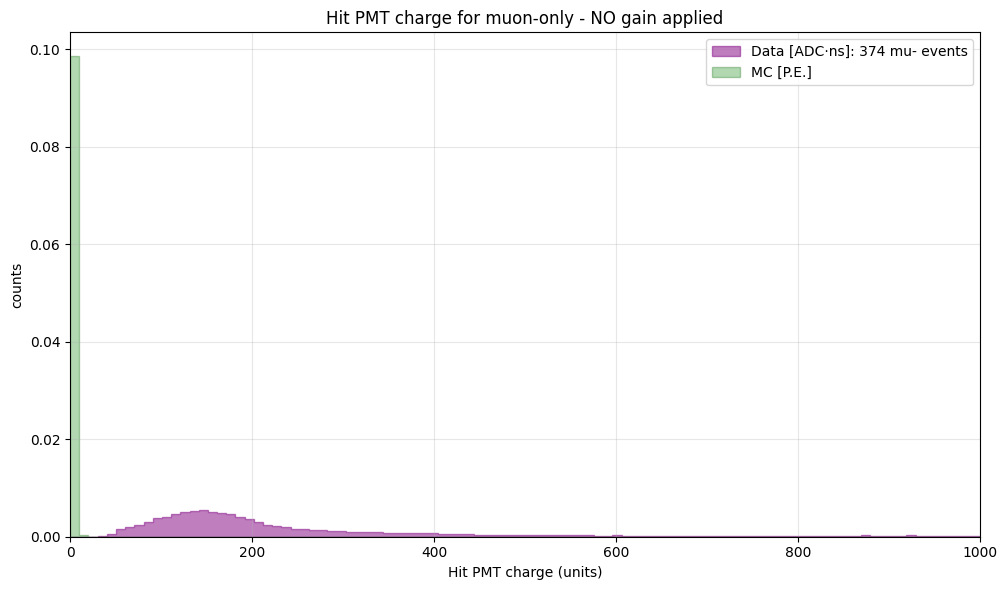

In [53]:
data_charges = ak.flatten(data["hit_pmt_charges"])
mc_charges   = ak.flatten(mc["hit_pmt_charges"])

min_range_charge = 0
max_range_charge = 1000

data_charges = data_charges[(data_charges >= min_range_charge) & (data_charges <= max_range_charge)]
mc_charges   = mc_charges[(mc_charges >= min_range_charge) & (mc_charges <= max_range_charge)]

bins = np.linspace(min_range_charge, max_range_charge, 100)

plt.figure(figsize=(10, 6))

# --- Histograms with edgecolor ---
plt.hist(data_charges, bins=bins, alpha=0.5, color='purple',
         label=f'Data [ADC·ns]: {len(data)} mu- events',
         histtype='stepfilled', density=True, edgecolor='purple')
plt.hist(mc_charges, bins=bins, alpha=0.3, color='green',
         label='MC [P.E.]',
         histtype='stepfilled', density=True, edgecolor='darkgreen')

#plt.yscale('log')
plt.xlabel('Hit PMT charge (units)')
plt.ylabel('counts')
plt.title('Hit PMT charge for muon-only - NO gain applied')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xlim(min_range_charge, max_range_charge)
plt.show()

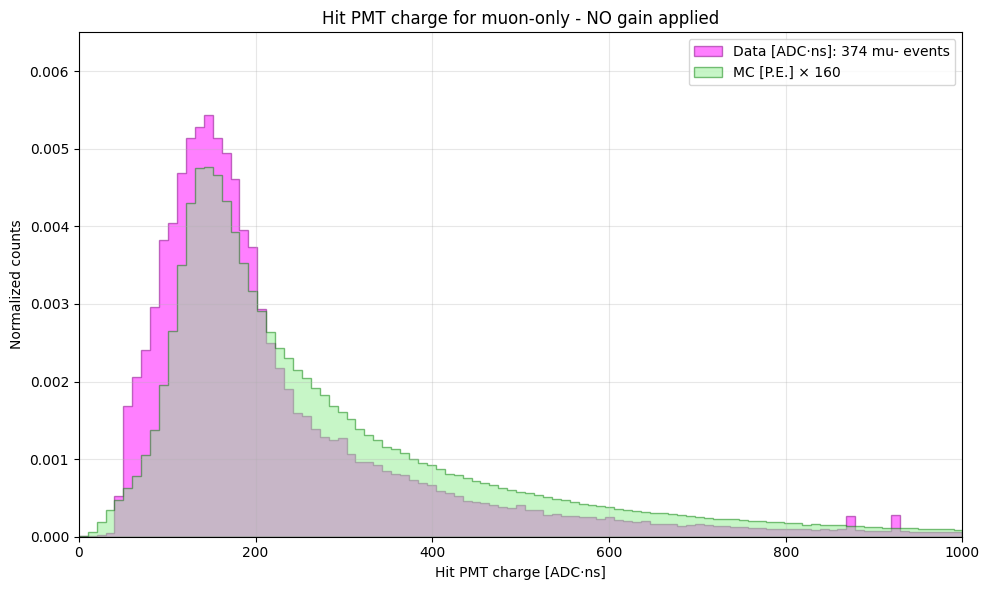

In [54]:
#flatten charges
data_charges = ak.to_numpy(ak.flatten(data["hit_pmt_charges"]))
mc_charges   = ak.to_numpy(ak.flatten(mc["hit_pmt_charges"])) * 160  # scale factor

#apply charge cuts
min_range_charge = 0
max_range_charge = 1000

data_charges = data_charges[(data_charges >= min_range_charge) & (data_charges <= max_range_charge)]
mc_charges   = mc_charges[(mc_charges >= min_range_charge) & (mc_charges <= max_range_charge)]


bins = np.linspace(min_range_charge, max_range_charge, 100)

plt.figure(figsize=(10, 6))
#data
plt.hist(data_charges, bins=bins, alpha=0.5, color='magenta',
         label=f'Data [ADC·ns]: {len(data)} mu- events',
         histtype='stepfilled', density=True, edgecolor='purple')
#MC
plt.hist(mc_charges, bins=bins, alpha=0.5, color='lightgreen',
         label='MC [P.E.] × 160',
         histtype='stepfilled', density=True, edgecolor='green')

plt.xlabel('Hit PMT charge [ADC·ns]')
plt.ylabel('Normalized counts')
plt.title('Hit PMT charge for muon-only - NO gain applied')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(min_range_charge, max_range_charge)
plt.ylim(0, 0.0065)
plt.yticks(np.linspace(0, 0.006, 7))  #0.0, 0.001, ..., 0.006
plt.tight_layout()
plt.show()

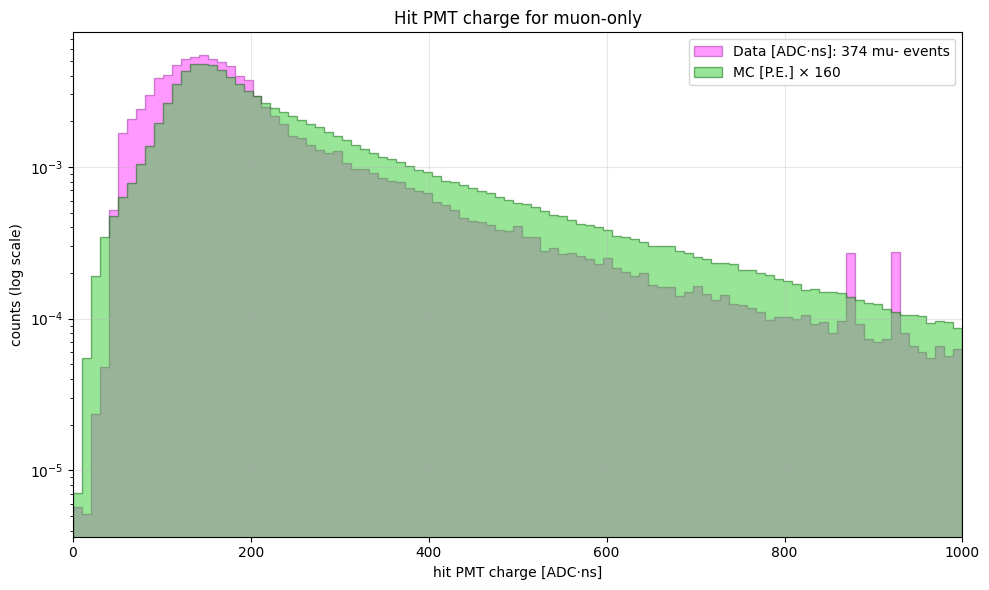

In [55]:
#usamos los mismos data_charges y mc_charges filtrados pion-only
#data_charges ya filtrado
#mc_charges raw ya filtrado
mc_charges_scaled = mc_charges * 160  # scale factor

min_range_charge = 0
max_range_charge = 1000
bins = np.linspace(min_range_charge, max_range_charge, 100)

#plot MC no escalado
plt.figure(figsize=(10, 6))
plt.hist(data_charges, bins=bins, alpha=0.4, color='magenta',
         label=f'Data [ADC·ns]: {len(data)} mu- events',
         histtype='stepfilled', density=True, edgecolor='purple')
plt.hist(mc_charges, bins=bins, alpha=0.5, color='limegreen',
         label='MC [P.E.] × 160',
         histtype='stepfilled', density=True, edgecolor='darkgreen')
plt.yscale('log')
plt.xlabel('hit PMT charge [ADC·ns]')
plt.ylabel('counts (log scale)')
plt.title('Hit PMT charge for muon-only')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(min_range_charge, max_range_charge)
plt.tight_layout()
plt.show()

In [56]:
print(mc.fields)
import numpy as np

unique_triggers = np.unique(mc["trigger_types"])
print(unique_triggers)

['event_number', 'window_time', 'run_id', 'sub_run_id', 'spill_counter', 'readout_number', 'hit_mpmt_card_ids', 'hit_pmt_channel_ids', 'hit_mpmt_slot_ids', 'hit_pmt_position_ids', 'hit_pmt_charges', 'hit_pmt_times', 'trigger_types', 'trigger_times', 'led_gains', 'led_dacsettings', 'led_ids', 'led_card_ids', 'led_slot_numbers', 'led_event_types', 'led_types', 'led_sequence_numbers', 'led_counters', 'beamline_pmt_qdc_charges', 'beamline_pmt_qdc_ids', 'beamline_pmt_tdc_times', 'beamline_pmt_tdc_ids']
[0]


In [57]:
npz_dir = "/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_MC-Data_Validation_with_GAIN_Calibration/"
n_chunks = 15
gain_file = [f"{npz_dir}NEW_doubleGauss_run2307_v3_chunk{i}.npz" for i in range(n_chunks+1)]   #GAIN RESULTS FROM run2307 (20/5/25)

#npz_dir = "/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/"
#gain_file = [f"{npz_dir}pmt_charge_fit_results_doubleGauss_{i}_[-5,2].npz" for i in range(n_chunks+1)]         #GAIN RESULTS FROM run2521  (4/6/25)
 

data_list = []
for f in gain_file:
    arr = np.load(f, allow_pickle=True)["results"]
    data_list.append(arr)


data_array = np.concatenate(data_list)


wcte_event_display_path = "/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_2025_commissioning/2025_data/WCTE_event_display"
sys.path.append(wcte_event_display_path)
from EventDisplay import EventDisplay

#mapping with EventDisplay
ed = EventDisplay()
ed.load_mPMT_positions("mPMT_2D_projection_angles.csv")


gain_per_channel = np.full(ed.nChannels, np.nan)
for i in range(len(data_array)):
    slot  = data_array['slot_id'][i]
    ch    = data_array['channel_id'][i]
    gain  = data_array['gain'][i]
    idx = 19 * slot + ch
    if idx < ed.nChannels:
        gain_per_channel[idx] = gain


mc_charges = ak.flatten(mc["hit_pmt_charges"])
mc_slot_ids = ak.flatten(mc["hit_mpmt_slot_ids"])
mc_channel_ids = ak.flatten(mc["hit_pmt_channel_ids"])


try:
    mc_slot_ids = ak.to_numpy(ak.flatten(mc["hit_mpmt_slot_ids"]))
    mc_channel_ids = ak.to_numpy(ak.flatten(mc["hit_pmt_channel_ids"]))
    valid_mask = (mc_slot_ids != -1)
    if np.sum(valid_mask) == 0:
        print("All MC slot IDs invalid → using unmasked charges.")
        mc_charges = ak.to_numpy(ak.flatten(mc["hit_pmt_charges"]))
    else:
        mc_charges = ak.to_numpy(ak.flatten(mc["hit_pmt_charges"]))[valid_mask]
except KeyError:
    print("MC has no slot/channel IDs → using unmasked charges.")
    mc_charges = ak.to_numpy(ak.flatten(mc["hit_pmt_charges"]))



mc_charges     = ak.to_numpy(mc_charges)
mc_slot_ids    = ak.to_numpy(mc_slot_ids)
mc_channel_ids = ak.to_numpy(mc_channel_ids)


data_charges = ak.to_numpy(ak.flatten(data["hit_pmt_charges"]))
data_slot_ids = ak.to_numpy(ak.flatten(data["hit_mpmt_slot_ids"]))
data_channel_ids = ak.to_numpy(ak.flatten(data["hit_pmt_channel_ids"]))

#ADC·ns --> P.E.
data_idx = 19 * data_slot_ids + data_channel_ids
data_charges_pe = data_charges / gain_per_channel[data_idx]


min_range_charge = 0
max_range_charge = 20

data_charges_pe = data_charges_pe[(data_charges_pe >= min_range_charge) & (data_charges_pe <= max_range_charge)]
mc_charges = mc_charges[(mc_charges >= min_range_charge) & (mc_charges <= max_range_charge)]

All MC slot IDs invalid → using unmasked charges.


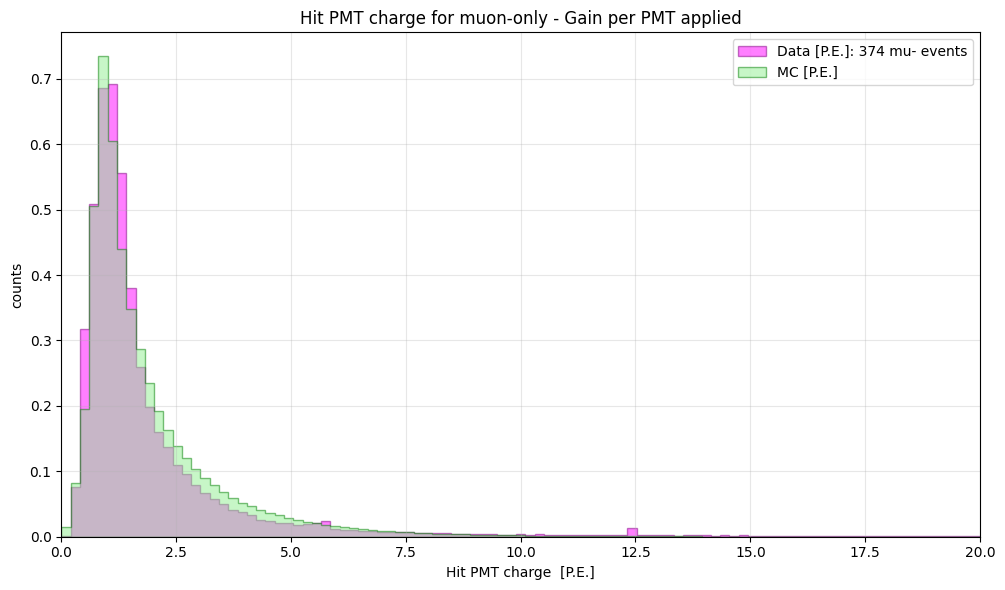

In [58]:
#plot data/MC aplicando el gain per PMT
bins = np.linspace(min_range_charge, max_range_charge, 100)

plt.figure(figsize=(10, 6))
plt.hist(data_charges_pe, bins=bins, alpha=0.5, color='magenta', label=f'Data [P.E.]: {len(data)} mu- events', 
         histtype='stepfilled', density=True, edgecolor='purple')
plt.hist(mc_charges, bins=bins, alpha=0.5, color='lightgreen', label='MC [P.E.]',
         histtype='stepfilled', density = True, edgecolor='green')

#plt.yscale("log")
plt.xlabel('Hit PMT charge  [P.E.]')
plt.ylabel('counts')
plt.title('Hit PMT charge for muon-only - Gain per PMT applied')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xlim(min_range_charge, max_range_charge)
plt.show()

Events (loaded)            : 374
Events with finite totals  : 374
Events with total == 0     : 0
Total hits (flattened)     : 180792
Valid hits with gain       : 177850 (98.4%)
Plottable Data events : 374
Plottable MC events   : 3000


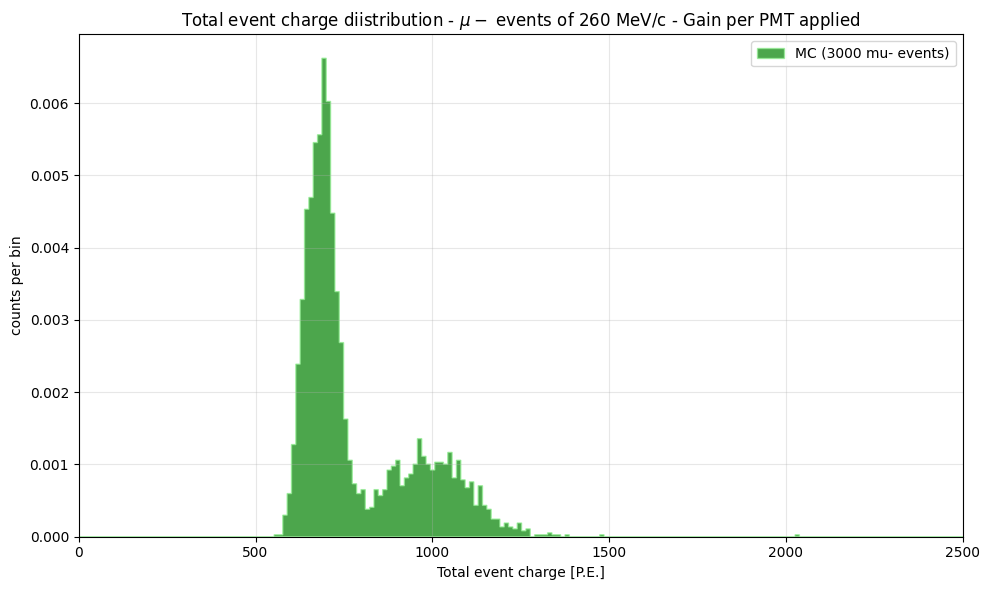

In [59]:
#flatten per-hit arrays (Awkward)
data_slot_ids = ak.to_numpy(ak.flatten(data["hit_mpmt_slot_ids"]))
data_channel_ids = ak.to_numpy(ak.flatten(data["hit_pmt_channel_ids"]))
data_charges = ak.to_numpy(ak.flatten(data["hit_pmt_charges"]))

#build PMT index 
data_idx = 19 * data_slot_ids + data_channel_ids

#shape-check
if len(data_idx) != len(data_charges):
    raise RuntimeError("Flattened hit arrays length mismatch!")

#safe per-hit correction: keep only hits with valid gains, set invalid hits to 0 ---
gain_for_hits = gain_per_channel[data_idx]              # may contain NaN
valid_gain_mask = np.isfinite(gain_for_hits) & (gain_for_hits > 0)

#convert invalid-hit charges to 0 (so event sums survive)
corrected_charges_pe_flat = np.zeros_like(data_charges, dtype=float)
corrected_charges_pe_flat[valid_gain_mask] = data_charges[valid_gain_mask] / gain_for_hits[valid_gain_mask]


#rebuild per-event structure using original per-event hit counts ---
n_hits_per_event = ak.num(data["hit_pmt_charges"], axis=1)
n_hits_total = int(np.sum(n_hits_per_event))



#if flatten length > expected total hits, trim; if <, raise error (data corruption)
if len(corrected_charges_pe_flat) < n_hits_total:
    raise RuntimeError(f"Fewer corrected hits ({len(corrected_charges_pe_flat)}) than expected total hits ({n_hits_total}).")
corrected_charges_pe_flat = corrected_charges_pe_flat[:n_hits_total]

data_event_charges_pe = ak.unflatten(corrected_charges_pe_flat, n_hits_per_event)

#???


#total charge per event (P.E.)
data_total_charge_per_event = ak.sum(data_event_charges_pe, axis=1)
data_total_charge_per_event = ak.to_numpy(data_total_charge_per_event)


n_events_before = len(data)
n_events_after = np.sum(np.isfinite(data_total_charge_per_event))
n_events_zero = np.sum(data_total_charge_per_event == 0)
n_valid_hits = np.sum(valid_gain_mask)

print(f"Events (loaded)            : {n_events_before}")
print(f"Events with finite totals  : {n_events_after}")
print(f"Events with total == 0     : {n_events_zero}")
print(f"Total hits (flattened)     : {len(data_charges)}")
print(f"Valid hits with gain       : {n_valid_hits} ({100*n_valid_hits/len(data_charges):.1f}%)")

#MC total charge per event (already in P.E.)
mc_total_charge_per_event = ak.sum(mc["hit_pmt_charges"], axis=1)
mc_total_charge_per_event = ak.to_numpy(mc_total_charge_per_event)

#clean NaN/non-positive values
mask_data_good = np.isfinite(data_total_charge_per_event) & (data_total_charge_per_event > 0)
mask_mc_good = np.isfinite(mc_total_charge_per_event) & (mc_total_charge_per_event > 0)

data_total = data_total_charge_per_event[mask_data_good]
mc_total = mc_total_charge_per_event[mask_mc_good]

print(f"Plottable Data events : {len(data_total)}")
print(f"Plottable MC events   : {len(mc_total)}")

#plot
# --- Plot total event charge distributions (sin líneas entre bins) ---
lo = 0
hi = max(data_total.max() if len(data_total) else 0, mc_total.max() if len(mc_total) else 0) * 1.05
if hi == 0:
    hi = 1.0
bins = np.linspace(lo, hi, 1000)

plt.figure(figsize=(10,6), dpi=100)
#plt.hist(data_total, bins=bins, alpha=0.7, color='magenta', histtype='stepfilled', edgecolor='magenta', density=True, label=f'Data ({len(data_total)} mu- events)')
plt.hist(mc_total, bins=bins, alpha=0.7, color='green', histtype='stepfilled', edgecolor='lightgreen', density=True,
         label=f'MC ({len(mc_total)} mu- events)')

plt.xlabel('Total event charge [P.E.]')
plt.ylabel('counts per bin')
plt.title('Total event charge diistribution - $\mu-$ events of 260 MeV/c - Gain per PMT applied')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0,2500)
plt.tight_layout()
plt.show()

In [60]:
npz_dir = "/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_MC-Data_Validation_with_GAIN_Calibration/"
n_chunks = 15
gain_file = [f"{npz_dir}twoStepfit_run2307_v2_chunk{i}.npz" for i in range(n_chunks+1)]   #GAIN RESULTS FROM run2307 (20/5/25)

#npz_dir = "/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/"
#gain_file = [f"{npz_dir}pmt_charge_fit_results_doubleGauss_{i}_[-5,2].npz" for i in range(n_chunks+1)]         #GAIN RESULTS FROM run2521  (4/6/25)
 

data_list = []
for f in gain_file:
    arr = np.load(f, allow_pickle=True)["results"]
    data_list.append(arr)


data_array = np.concatenate(data_list)


wcte_event_display_path = "/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_2025_commissioning/2025_data/WCTE_event_display"
sys.path.append(wcte_event_display_path)
from EventDisplay import EventDisplay

#mapping with EventDisplay
ed = EventDisplay()
ed.load_mPMT_positions("mPMT_2D_projection_angles.csv")


gain_per_channel = np.full(ed.nChannels, np.nan)
for i in range(len(data_array)):
    slot  = data_array['slot_id'][i]
    ch    = data_array['channel_id'][i]
    gain  = data_array['gain'][i]
    idx = 19 * slot + ch
    if idx < ed.nChannels:
        gain_per_channel[idx] = gain


mc_charges = ak.flatten(mc["hit_pmt_charges"])
mc_slot_ids = ak.flatten(mc["hit_mpmt_slot_ids"])
mc_channel_ids = ak.flatten(mc["hit_pmt_channel_ids"])


try:
    mc_slot_ids = ak.to_numpy(ak.flatten(mc["hit_mpmt_slot_ids"]))
    mc_channel_ids = ak.to_numpy(ak.flatten(mc["hit_pmt_channel_ids"]))
    valid_mask = (mc_slot_ids != -1)
    if np.sum(valid_mask) == 0:
        print("All MC slot IDs invalid → using unmasked charges.")
        mc_charges = ak.to_numpy(ak.flatten(mc["hit_pmt_charges"]))
    else:
        mc_charges = ak.to_numpy(ak.flatten(mc["hit_pmt_charges"]))[valid_mask]
except KeyError:
    print("MC has no slot/channel IDs → using unmasked charges.")
    mc_charges = ak.to_numpy(ak.flatten(mc["hit_pmt_charges"]))



mc_charges     = ak.to_numpy(mc_charges)
mc_slot_ids    = ak.to_numpy(mc_slot_ids)
mc_channel_ids = ak.to_numpy(mc_channel_ids)


data_charges = ak.to_numpy(ak.flatten(data["hit_pmt_charges"]))
data_slot_ids = ak.to_numpy(ak.flatten(data["hit_mpmt_slot_ids"]))
data_channel_ids = ak.to_numpy(ak.flatten(data["hit_pmt_channel_ids"]))

#ADC·ns --> P.E.
data_idx = 19 * data_slot_ids + data_channel_ids
data_charges_pe = data_charges / gain_per_channel[data_idx]


min_range_charge = 0
max_range_charge = 20

data_charges_pe = data_charges_pe[(data_charges_pe >= min_range_charge) & (data_charges_pe <= max_range_charge)]
mc_charges = mc_charges[(mc_charges >= min_range_charge) & (mc_charges <= max_range_charge)]

All MC slot IDs invalid → using unmasked charges.


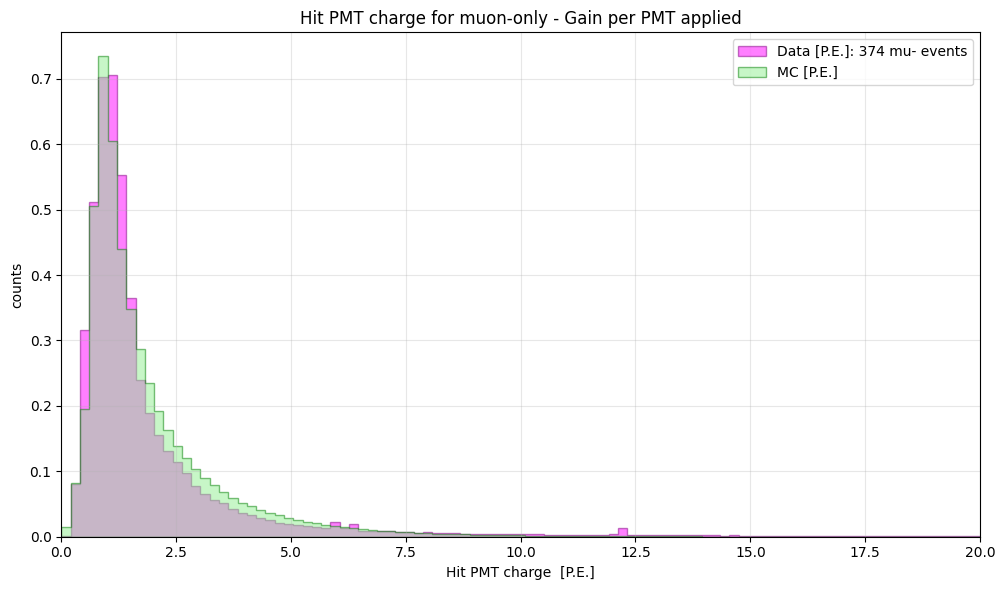

In [61]:
#plot data/MC aplicando el gain per PMT
bins = np.linspace(min_range_charge, max_range_charge, 100)

plt.figure(figsize=(10, 6))
plt.hist(data_charges_pe, bins=bins, alpha=0.5, color='magenta', label=f'Data [P.E.]: {len(data)} mu- events', 
         histtype='stepfilled', density=True, edgecolor='purple')
plt.hist(mc_charges, bins=bins, alpha=0.5, color='lightgreen', label='MC [P.E.]',
         histtype='stepfilled', density = True, edgecolor='green')

#plt.yscale("log")
plt.xlabel('Hit PMT charge  [P.E.]')
plt.ylabel('counts')
plt.title('Hit PMT charge for muon-only - Gain per PMT applied')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xlim(min_range_charge, max_range_charge)
plt.show()

Events (loaded)            : 374
Events with finite totals  : 374
Events with total == 0     : 0
Total hits (flattened)     : 180792
Valid hits with gain       : 175218 (96.9%)
Plottable Data events : 374
Plottable MC events   : 3000


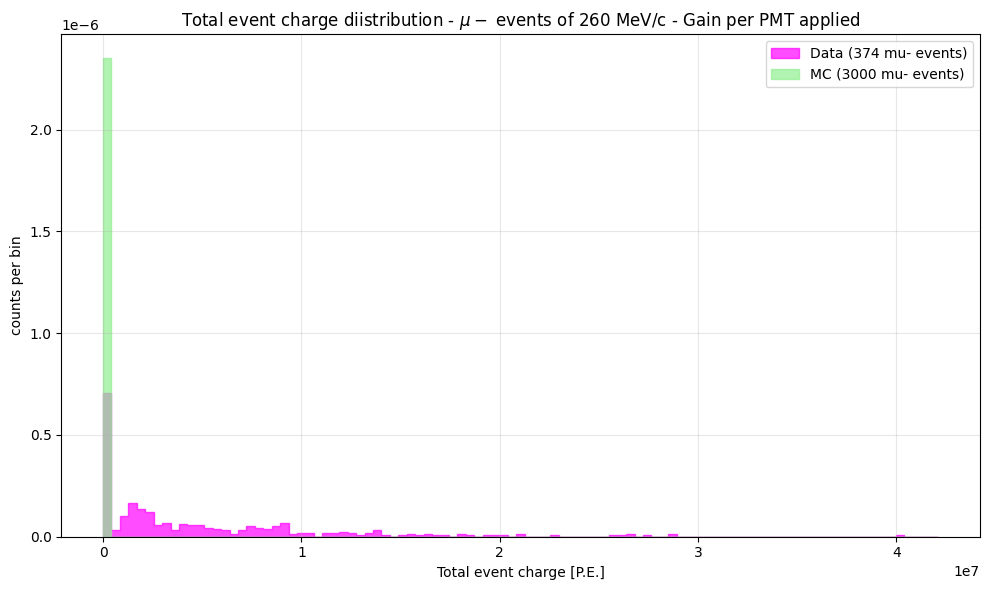

In [68]:
#flatten per-hit arrays (Awkward)
data_slot_ids = ak.to_numpy(ak.flatten(data["hit_mpmt_slot_ids"]))
data_channel_ids = ak.to_numpy(ak.flatten(data["hit_pmt_channel_ids"]))
data_charges = ak.to_numpy(ak.flatten(data["hit_pmt_charges"]))

#build PMT index 
data_idx = 19 * data_slot_ids + data_channel_ids

#shape-check
if len(data_idx) != len(data_charges):
    raise RuntimeError("Flattened hit arrays length mismatch!")

#safe per-hit correction: keep only hits with valid gains, set invalid hits to 0 ---
gain_for_hits = gain_per_channel[data_idx]              # may contain NaN
valid_gain_mask = np.isfinite(gain_for_hits) & (gain_for_hits > 0)

#convert invalid-hit charges to 0 (so event sums survive)
corrected_charges_pe_flat = np.zeros_like(data_charges, dtype=float)
corrected_charges_pe_flat[valid_gain_mask] = data_charges[valid_gain_mask] / gain_for_hits[valid_gain_mask]


#rebuild per-event structure using original per-event hit counts ---
n_hits_per_event = ak.num(data["hit_pmt_charges"], axis=1)
n_hits_total = int(np.sum(n_hits_per_event))



#if flatten length > expected total hits, trim; if <, raise error (data corruption)
if len(corrected_charges_pe_flat) < n_hits_total:
    raise RuntimeError(f"Fewer corrected hits ({len(corrected_charges_pe_flat)}) than expected total hits ({n_hits_total}).")
corrected_charges_pe_flat = corrected_charges_pe_flat[:n_hits_total]

data_event_charges_pe = ak.unflatten(corrected_charges_pe_flat, n_hits_per_event)

#???


#total charge per event (P.E.)
data_total_charge_per_event = ak.sum(data_event_charges_pe, axis=1)
data_total_charge_per_event = ak.to_numpy(data_total_charge_per_event)


n_events_before = len(data)
n_events_after = np.sum(np.isfinite(data_total_charge_per_event))
n_events_zero = np.sum(data_total_charge_per_event == 0)
n_valid_hits = np.sum(valid_gain_mask)

print(f"Events (loaded)            : {n_events_before}")
print(f"Events with finite totals  : {n_events_after}")
print(f"Events with total == 0     : {n_events_zero}")
print(f"Total hits (flattened)     : {len(data_charges)}")
print(f"Valid hits with gain       : {n_valid_hits} ({100*n_valid_hits/len(data_charges):.1f}%)")

#MC total charge per event (already in P.E.)
mc_total_charge_per_event = ak.sum(mc["hit_pmt_charges"], axis=1)
mc_total_charge_per_event = ak.to_numpy(mc_total_charge_per_event)

#clean NaN/non-positive values
mask_data_good = np.isfinite(data_total_charge_per_event) & (data_total_charge_per_event > 0)
mask_mc_good = np.isfinite(mc_total_charge_per_event) & (mc_total_charge_per_event > 0)

data_total = data_total_charge_per_event[mask_data_good]
mc_total = mc_total_charge_per_event[mask_mc_good]

print(f"Plottable Data events : {len(data_total)}")
print(f"Plottable MC events   : {len(mc_total)}")

#plot
# --- Plot total event charge distributions (sin líneas entre bins) ---
lo = 0
hi = max(data_total.max() if len(data_total) else 0, mc_total.max() if len(mc_total) else 0) * 1.05
if hi == 0:
    hi = 1.0
bins = np.linspace(lo, hi, 100)

plt.figure(figsize=(10,6), dpi=100)
plt.hist(data_total, bins=bins, alpha=0.7, color='magenta', histtype='stepfilled', edgecolor='magenta', density=True, label=f'Data ({len(data_total)} mu- events)')
plt.hist(mc_total, bins=bins, alpha=0.7, color='lightgreen', histtype='stepfilled', edgecolor='lightgreen', density=True,
         label=f'MC ({len(mc_total)} mu- events)')

plt.xlabel('Total event charge [P.E.]')
plt.ylabel('counts per bin')
plt.title('Total event charge diistribution - $\mu-$ events of 260 MeV/c - Gain per PMT applied')
plt.legend()
plt.grid(True, alpha=0.3)
#plt.xlim(0,2500)
plt.tight_layout()
plt.show()

Valid PMTs: 1538 / 2014
Valid Data events: 374
MC events (all, masked PMTs): 3000


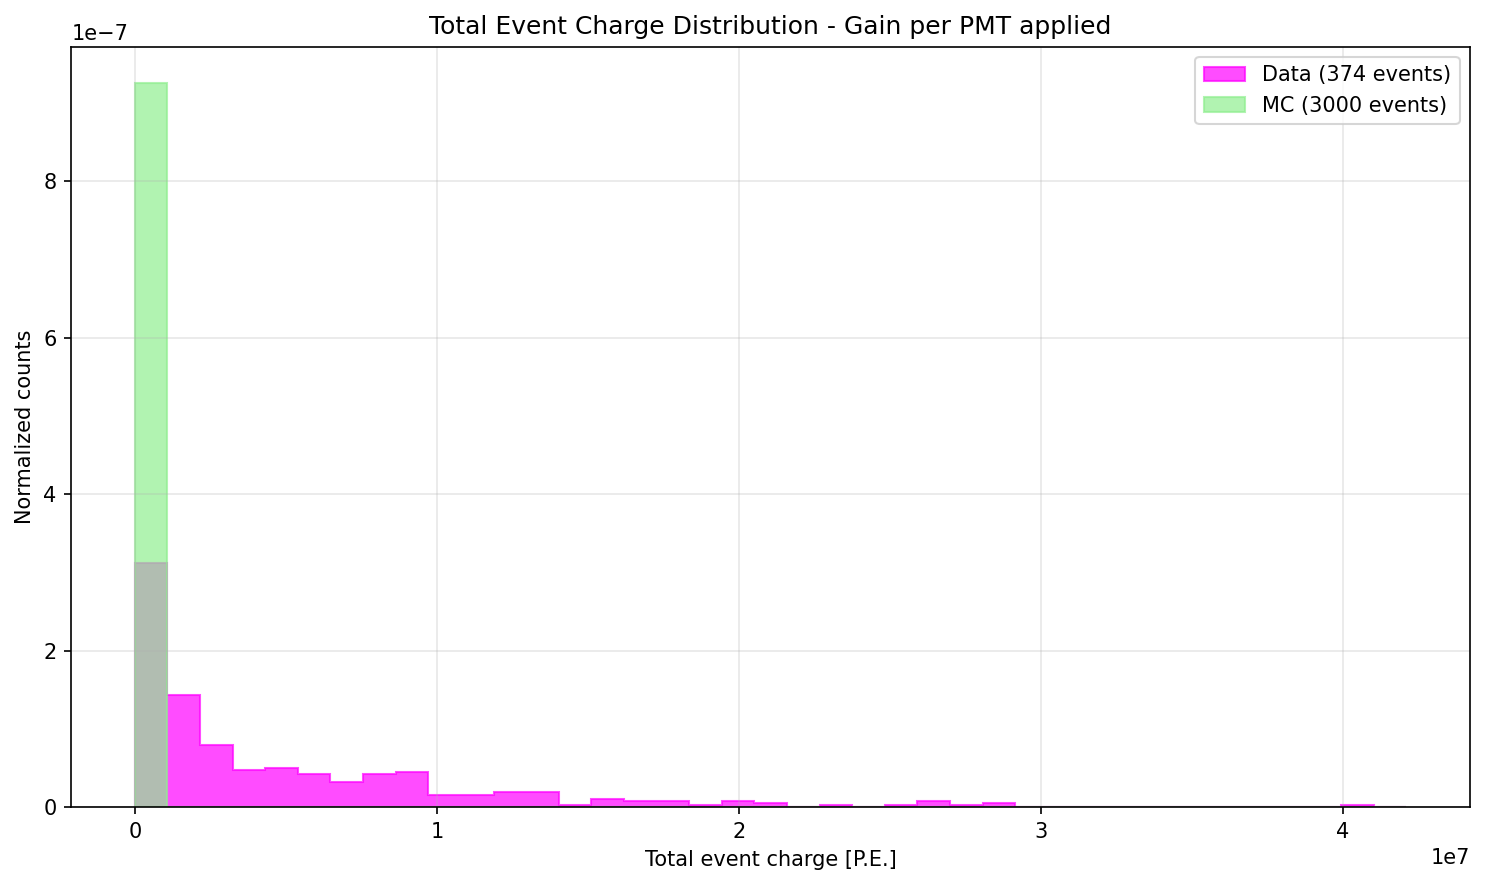

In [63]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

# ------------------------
# Global mask: PMTs with valid gain in Data
# ------------------------
valid_pmts_mask = np.isfinite(gain_per_channel) & (gain_per_channel > 0)
valid_indices = np.where(valid_pmts_mask)[0]
print(f"Valid PMTs: {np.sum(valid_pmts_mask)} / {len(gain_per_channel)}")

# ------------------------
# DATA
# ------------------------
slot_ids_data = data["hit_mpmt_slot_ids"]
chan_ids_data = data["hit_pmt_channel_ids"]
charges_data = data["hit_pmt_charges"]

idx_data = 19 * slot_ids_data + chan_ids_data
flat_idx_data = ak.to_numpy(ak.flatten(idx_data))
flat_valid_mask_data = np.isin(flat_idx_data, valid_indices)
valid_mask_data = ak.unflatten(flat_valid_mask_data, ak.num(idx_data, axis=1))

charges_data_valid = charges_data[valid_mask_data]
idx_data_valid = idx_data[valid_mask_data]

flat_idx_data_valid = ak.to_numpy(ak.flatten(idx_data_valid))
flat_gain_data = gain_per_channel[flat_idx_data_valid]
gain_for_data_ak = ak.unflatten(flat_gain_data, ak.num(idx_data_valid, axis=1))

charges_pe_data = charges_data_valid / gain_for_data_ak

data_total_charge_per_event = ak.sum(charges_pe_data, axis=1)
data_total_charge_per_event = ak.to_numpy(data_total_charge_per_event[np.isfinite(data_total_charge_per_event)])
print(f"Valid Data events: {len(data_total_charge_per_event)}")

# ------------------------
# MC
# ------------------------
slot_ids_mc = mc["hit_mpmt_slot_ids"]
chan_ids_mc = mc["hit_pmt_channel_ids"]
charges_mc = mc["hit_pmt_charges"]

idx_mc = 19 * slot_ids_mc + chan_ids_mc
flat_idx_mc = ak.to_numpy(ak.flatten(idx_mc))
flat_charges_mc = ak.to_numpy(ak.flatten(charges_mc))

# Mask MC hits to use only valid PMTs
flat_valid_mask_mc = np.isin(flat_idx_mc, valid_indices)
flat_charges_mc_valid = flat_charges_mc[flat_valid_mask_mc]

# Rebuild per-event structure
n_hits_per_event_mc = ak.num(charges_mc, axis=1)
mc_total_charge_per_event = []
start = 0
for nh in n_hits_per_event_mc:
    end = start + nh
    # Sum only the hits that survive the valid PMT mask
    mc_total_charge_per_event.append(np.sum(flat_charges_mc_valid[start:end]))
    start = end
mc_total_charge_per_event = np.array(mc_total_charge_per_event)

# Filter finite
mc_total_charge_per_event = mc_total_charge_per_event[np.isfinite(mc_total_charge_per_event)]
print(f"MC events (all, masked PMTs): {len(mc_total_charge_per_event)}")

# ------------------------
# Plot
# ------------------------
lo = 0
hi = max(np.nanmax(data_total_charge_per_event), np.nanmax(mc_total_charge_per_event)) * 1.05
bins = np.linspace(lo, hi, 40)

plt.figure(figsize=(10,6), dpi=150)
plt.hist(data_total_charge_per_event, bins=bins, alpha=0.7, color='magenta',
         histtype='stepfilled', edgecolor='magenta', density=True,
         label=f'Data ({len(data_total_charge_per_event)} events)')
plt.hist(mc_total_charge_per_event, bins=bins, alpha=0.7, color='lightgreen',
         histtype='stepfilled', edgecolor='lightgreen', density=True,
         label=f'MC ({len(mc_total_charge_per_event)} events)')

plt.xlabel('Total event charge [P.E.]')
plt.ylabel('Normalized counts')
plt.title('Total Event Charge Distribution - Gain per PMT applied')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Valid PMTs: 1538 / 2014
Valid Data events: 374
MC events after resampling: 374


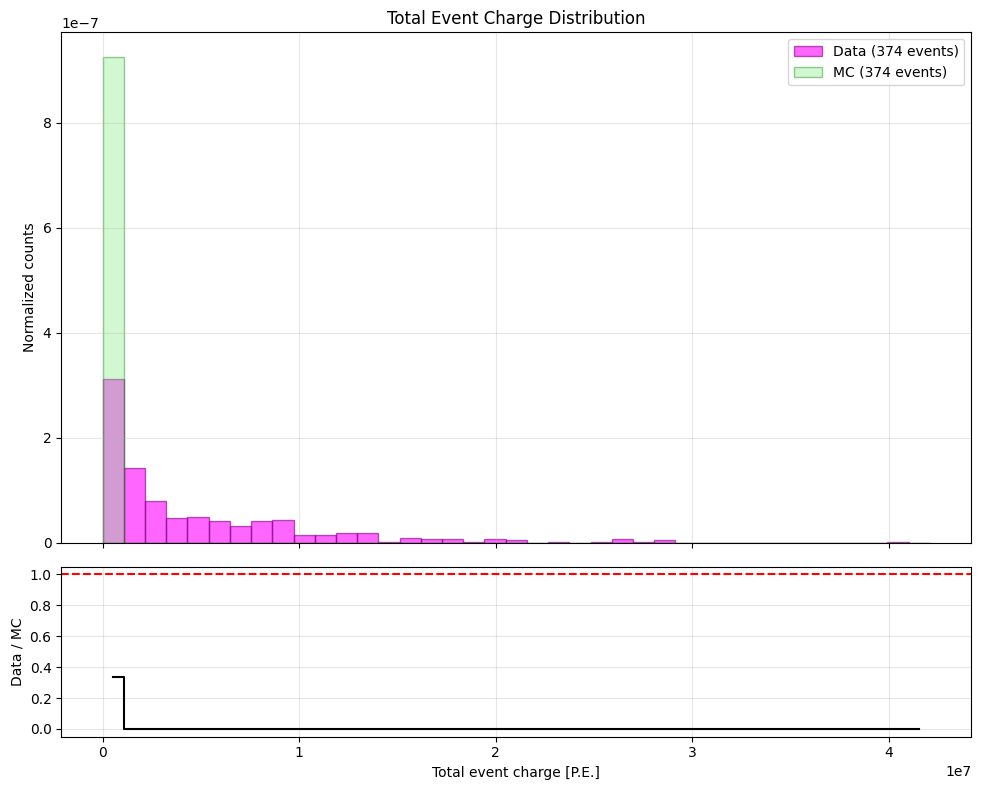

In [64]:
#global mask for valid PMTs(Data)

valid_pmts_mask = np.isfinite(gain_per_channel) & (gain_per_channel > 0)
valid_indices = np.where(valid_pmts_mask)[0]
print(f"Valid PMTs: {np.sum(valid_pmts_mask)} / {len(gain_per_channel)}")


#DATA

slot_ids_data = data["hit_mpmt_slot_ids"]
chan_ids_data = data["hit_pmt_channel_ids"]
charges_data = data["hit_pmt_charges"]

#unique index per PMT
idx_data = 19 * slot_ids_data + chan_ids_data

#convertir a plano para aplicar np.isin
flat_idx_data = ak.to_numpy(ak.flatten(idx_data))
flat_valid_mask = np.isin(flat_idx_data, valid_indices)

#reconstruir máscara awkward con la misma estructura que idx_data
valid_mask_data = ak.unflatten(flat_valid_mask, ak.num(idx_data, axis=1))

#apply mask
charges_data_valid = charges_data[valid_mask_data]
idx_data_valid = idx_data[valid_mask_data]

#apply gain
flat_idx_data_valid = ak.to_numpy(ak.flatten(idx_data_valid))
flat_gain_data = gain_per_channel[flat_idx_data_valid]
gain_for_data_ak = ak.unflatten(flat_gain_data, ak.num(idx_data_valid, axis=1))

charges_pe_data = charges_data_valid / gain_for_data_ak

#total sum per event
data_total_charge_per_event = ak.sum(charges_pe_data, axis=1)
data_total_charge_per_event = ak.to_numpy(data_total_charge_per_event[np.isfinite(data_total_charge_per_event)])
print(f"Valid Data events: {len(data_total_charge_per_event)}")



#MC

charges_mc = mc["hit_pmt_charges"]

# total por evento (sin aplicar máscara ni gain)
mc_total_charge_per_event = ak.sum(charges_mc, axis=1)
mc_total_charge_per_event = ak.to_numpy(mc_total_charge_per_event[np.isfinite(mc_total_charge_per_event)])

# igualar número de eventos Data ↔ MC
if len(mc_total_charge_per_event) > len(data_total_charge_per_event):
    np.random.seed(42)
    mc_total_charge_per_event = np.random.choice(mc_total_charge_per_event,
                                                 len(data_total_charge_per_event),
                                                 replace=False)

print(f"MC events after resampling: {len(mc_total_charge_per_event)}")




#plot

lo = 0
hi = max(np.nanmax(data_total_charge_per_event), np.nanmax(mc_total_charge_per_event)) * 1.05
bins = np.linspace(lo, hi, 40)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), gridspec_kw={'height_ratios':[3,1]}, sharex=True)

hist_data, edges = np.histogram(data_total_charge_per_event, bins=bins, density=True)
hist_mc, _ = np.histogram(mc_total_charge_per_event, bins=bins, density=True)


ax1.hist(data_total_charge_per_event, bins=bins, alpha=0.6, color='magenta', label=f'Data ({len(data_total_charge_per_event)} events)', density=True, edgecolor='purple')
ax1.hist(mc_total_charge_per_event, bins=bins, alpha=0.4, color='lightgreen', label=f'MC ({len(mc_total_charge_per_event)} events)', density=True, edgecolor='green')

ax1.set_ylabel('Normalized counts')
ax1.set_title('Total Event Charge Distribution')
ax1.legend()
ax1.grid(alpha=0.3)


#ratio plot
ratio = np.divide(hist_data, hist_mc, out=np.zeros_like(hist_data), where=hist_mc!=0)
bin_centers = 0.5*(edges[1:] + edges[:-1])
ax2.step(bin_centers, ratio, where='mid', color='black')
ax2.axhline(1.0, color='red', linestyle='--')
ax2.set_xlabel('Total event charge [P.E.]')
ax2.set_ylabel('Data / MC')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

1564/2014 --> ~77.65% de los PMTs tienen gain calibration result, y por tanto no se descartan

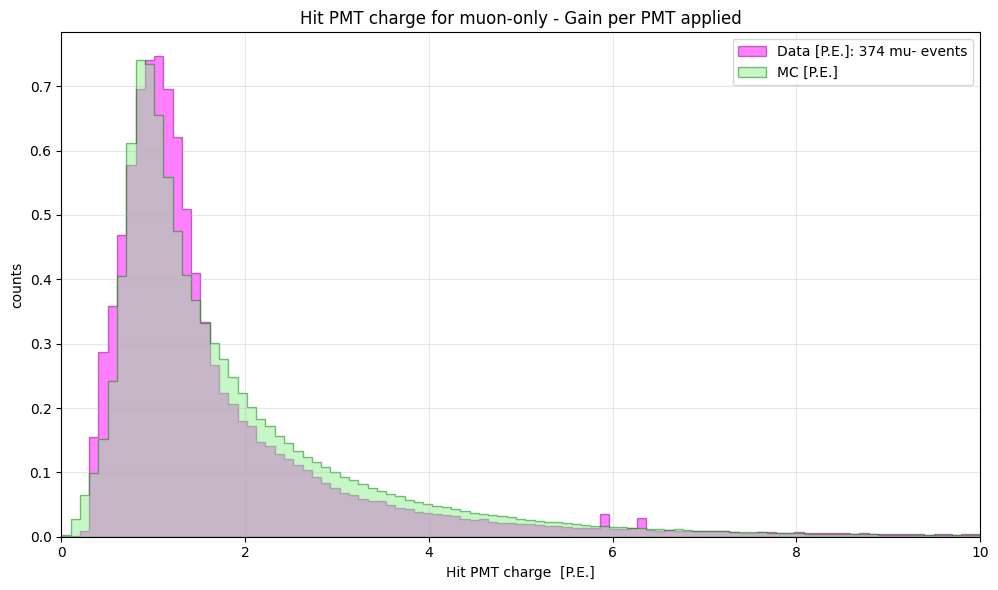

In [65]:
#same as before but MC wighted to MC number of events
mc_weights = np.ones_like(mc_charges)*(len(data_charges_pe) / len(mc_charges))

bins = np.linspace(min_range_charge, 10, 100)

plt.figure(figsize=(10, 6))
plt.hist(data_charges_pe, bins=bins, alpha=0.5, color='magenta', label=f'Data [P.E.]: {len(data)} mu- events', 
         histtype='stepfilled', density=True, edgecolor='purple')
plt.hist(mc_charges, bins=bins, alpha=0.5, color='lightgreen', label='MC [P.E.]',  weights=mc_weights,
         histtype='stepfilled', density = True, edgecolor='green')

#plt.yscale("log")
plt.xlabel('Hit PMT charge  [P.E.]')
plt.ylabel('counts')
plt.title('Hit PMT charge for muon-only - Gain per PMT applied')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xlim(min_range_charge, 10)
plt.show()

In [66]:
#lo = min(np.min(data_charges_pe), np.min(mc_charges), min_range_charge)
lo = 15
hi = 10
bins = np.linspace(lo, hi, 100)

#Histogram **counts** --> so statistics are meaningful
data_counts, _ = np.histogram(data_charges_pe, bins=bins)
mc_counts, _   = np.histogram(mc_charges, bins=bins, weights=mc_weights)

#for weighted MC, variance is sum of w^2 per bin
mc_w2, _       = np.histogram(mc_charges, bins=bins, weights=mc_weights**2)

#only take ratio where both sides have entries
valid = (mc_counts > 0) & (data_counts > 0)


ratio = np.full_like(mc_counts, np.nan, dtype=float)
ratio[valid] = data_counts[valid] / mc_counts[valid]

data_err = np.sqrt(data_counts.astype(float))
mc_err   = np.sqrt(mc_w2)
ratio_err = np.full_like(ratio, np.nan, dtype=float)
ratio_err[valid] = ratio[valid] * np.sqrt((data_err[valid]/data_counts[valid])**2 + (mc_err[valid]/mc_counts[valid])**2)


bin_centers = 0.5*(bins[:-1] + bins[1:])
plt.figure(figsize=(10,8), dpi=180)
gs = plt.GridSpec(2,1, height_ratios=[3,1], hspace=0.05)


ax = plt.subplot(gs[0])
ax.hist(data_charges_pe, bins=bins, alpha=0.5, color='magenta', label=f'Data [P.E.]: {len(data)} mu- events', 
        histtype='stepfilled', density=True, edgecolor='purple')
ax.hist(mc_charges, bins=bins, alpha=0.5, color='lightgreen', label='MC [P.E.]', weights=mc_weights,
        histtype='stepfilled', density=True, edgecolor='green')
ax.set_ylabel('counts')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(lo, hi)
ax.set_ylim(0, 0.9)  # límite superior del eje y
ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])  # ticks hasta 0.8
ax.set_title('Hit PMT charge for muon-only - Gain per PMT applied')

# Ratio plot
axr = plt.subplot(gs[1], sharex=ax)
axr.errorbar(bin_centers[valid], ratio[valid], yerr=ratio_err[valid], fmt='o', ms=3)
axr.axhline(1.0, color='red', linestyle='--', label="ratio=1.0")
axr.set_ylim(0, 3)  # el eje llega hasta 5
axr.set_yticks([0, 1, 2, 3])  # no mostrar el 5
axr.legend()
axr.set_xlabel('Hit PMT charge [P.E.]')
axr.set_ylabel('Data / MC')
axr.grid(True, alpha=0.3)

plt.setp(ax.get_xticklabels(), visible=False)  # hide top x labels
plt.tight_layout()
plt.show()


ValueError: `bins` must increase monotonically, when an array

In [ ]:
print(results.dtype)

NameError: name 'results' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# --- Matplotlib formatting ---
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [11, 8]
rcParams['font.size'] = 22
rcParams['axes.labelsize'] = 20
rcParams['axes.titlesize'] = 20
rcParams['legend.fontsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16

# --- Histogram setup ---
lo = min(np.min(data_charges_pe), np.min(mc_charges), min_range_charge)
hi = 10
bins = np.linspace(lo, hi, 100)
# --- Normalize charges by PMT mean SPE ---
# Assuming you have arrays: `data_charges_pe` and `data_pmts` with PMT indices per hit
# and `mc_charges` with `mc_pmts` indices per MC hit
# `mu_spe` contains mean SPE per PMT

# Apply per-PMT normalization
data_charges_norm = data_charges_pe / mu_spe[data_pmts]
mc_charges_norm   = mc_charges / mu_spe[mc_pmts]

# Histogram setup
lo = min(np.min(data_charges_norm), np.min(mc_charges_norm), min_range_charge)
hi = 10
bins = np.linspace(lo, hi, 100)

# Histogram counts
data_counts, _ = np.histogram(data_charges_norm, bins=bins)
mc_counts, _   = np.histogram(mc_charges_norm, bins=bins, weights=mc_weights)
mc_w2, _       = np.histogram(mc_charges_norm, bins=bins, weights=mc_weights**2)

# Only consider bins with entries
valid = (mc_counts > 0) & (data_counts > 0)

# Ratio and propagated error
ratio = np.full_like(mc_counts, np.nan, dtype=float)
ratio[valid] = data_counts[valid] / mc_counts[valid]

data_err = np.sqrt(data_counts.astype(float))
mc_err   = np.sqrt(mc_w2)
ratio_err = np.full_like(ratio, np.nan, dtype=float)
ratio_err[valid] = ratio[valid] * np.sqrt((data_err[valid]/data_counts[valid])**2 + 
                                          (mc_err[valid]/mc_counts[valid])**2)

bin_centers = 0.5*(bins[:-1] + bins[1:])

# --- Plot ---
fig = plt.figure(figsize=(11, 8), dpi=180)
gs = plt.GridSpec(2,1, height_ratios=[3,1], hspace=0.05)

# Top: data vs MC
ax = plt.subplot(gs[0])
ax.hist(data_charges_norm, bins=bins, alpha=0.5, color='magenta',
        label=f'Data [P.E. normalized]: {len(data_charges_pe)} mu- events',
        histtype='stepfilled', density=True, edgecolor='purple')
ax.hist(mc_charges_norm, bins=bins, alpha=0.5, color='lightgreen',
        label='MC [P.E. normalized]', weights=mc_weights,
        histtype='stepfilled', density=True, edgecolor='green')
ax.set_ylabel('counts')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(lo, hi)
ax.set_ylim(0, 0.9)
ax.set_yticks(np.arange(0, 0.9+0.1, 0.1))
ax.set_title('Hit PMT charge for muon-only - normalized by PMT μ_SPE')

# Bottom: ratio
axr = plt.subplot(gs[1], sharex=ax)
axr.errorbar(bin_centers[valid], ratio[valid], yerr=ratio_err[valid],
             fmt='o', ms=4, color='gray', ecolor='gray', capsize=2)
axr.axhline(1.0, color='red', linestyle='--', label="ratio = 1.0")
axr.set_ylim(0, 3)
axr.set_yticks([0, 1, 2, 3])
axr.legend()
axr.set_xlabel('Hit PMT charge / μ_SPE')
axr.set_ylabel('Data / MC')
axr.grid(True, alpha=0.3)

plt.setp(ax.get_xticklabels(), visible=False)  # hide top x-axis labels
plt.tight_layout()
plt.show()

NameError: name 'mu_spe' is not defined

In [ ]:
# 1. Load MC fields
tube_ids = ak.to_numpy(ak.flatten(mc["hit_pmt_ids"]))
mc_charges = ak.to_numpy(ak.flatten(mc["hit_pmt_charges"]))

# 2. Load mapping from the WCTE event display repo
mapping = pd.read_csv("geofile_WCTE.txt", delim_whitespace=True,
                      names=["tube_id", "slot_id", "pmt_position"])

# 3. Merge MC hits with mapping
mc_df = pd.DataFrame({"tube_id": tube_ids, "charge": mc_charges})
mc_df = mc_df.merge(mapping, on="tube_id", how="left")

# 4. Drop invalid ones
mc_df = mc_df.dropna(subset=["slot_id", "pmt_position"])

# 5. Extract arrays
mc_slots = mc_df["slot_id"].astype(int).to_numpy()
mc_positions = mc_df["pmt_position"].astype(int).to_numpy()
mc_charges = mc_df["charge"].to_numpy()

# (Optional) Compute PMT IDs for consistency with Data
mc_pmt_ids = 19 * mc_slots + mc_positions

ValueError: key "hit_pmt_ids" does not exist (not in record)

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.5/src/libawkward/util.cpp#L525)

In [ ]:
#mPMT slot ids

data_slots = ak.flatten(data["hit_mpmt_slot_ids"])
mc_slots = ak.flatten(mc["hit_mpmt_slot_ids"])

min_slot = int(min(ak.min(data_slots), ak.min(mc_slots)))
max_slot = int(max(ak.max(data_slots), ak.max(mc_slots)))

bins = np.arange(min_slot, max_slot, 1) 

plt.figure(figsize=(10, 6))
plt.hist(data_slots, bins=bins, alpha=0.6, label=f'Data: {len(data)} events', histtype='stepfilled', density=True)
plt.hist(mc_slots, bins=bins, alpha=0.6, label='MC', histtype='stepfilled', density=True)

plt.xlabel('mPMT slot ID')
plt.ylabel('Normalized counts')
plt.title('Hit mPMT slot ID')
plt.legend()
plt.tight_layout()
plt.xticks(np.arange(min_slot, max_slot))  

plt.show()

TypeError: '>' not supported between instances of 'int' and 'NoneType'

- We want slot_ids vs. charge (not only vs counts)

- Let's identify and separate PMT ids

In [ ]:
#convert 1D flatten arrays into Numpy arrays
data_slots = ak.to_numpy(ak.flatten(data["hit_mpmt_slot_ids"]))
data_charges = ak.to_numpy(ak.flatten(data["hit_pmt_charges"]))     #data_charges = ak.flatten(data["hit_pmt_charges"])
data_channels = ak.to_numpy(ak.flatten(data["hit_pmt_channel_ids"]))
data_positions = ak.to_numpy(ak.flatten(data["hit_pmt_position_ids"]))

mc_slots = ak.to_numpy(ak.flatten(mc["hit_mpmt_slot_ids"]))
mc_charges = ak.to_numpy(ak.flatten(mc["hit_pmt_charges"]))
mc_channels = ak.to_numpy(ak.flatten(mc["hit_pmt_channel_ids"]))
mc_positions = ak.to_numpy(ak.flatten(mc["hit_pmt_position_ids"]))


#aligning slot_id and charge pairs correctly with zip
valid_data = [
    (slot, charge, channel, position)
    for slot_list, charge_list, channel_list, pos_list in zip(
        data["hit_mpmt_slot_ids"],
        data["hit_pmt_charges"],
        data["hit_pmt_channel_ids"],
        data["hit_pmt_position_ids"]
    )
    for slot, charge, channel, position in zip(slot_list, charge_list, channel_list, pos_list)
    if slot != -1  
]

valid_mc = [
    (slot, charge, channel, position)
    for slot_list, charge_list, channel_list, pos_list in zip(
        mc["hit_mpmt_slot_ids"],
        mc["hit_pmt_charges"],
        mc["hit_pmt_channel_ids"],
        mc["hit_pmt_position_ids"]
    )
    for slot, charge, channel, position in zip(slot_list, charge_list, channel_list, pos_list)
]


#unpack en arrays alineados
data_slots, data_charges, data_channels, data_positions = zip(*valid_data)
data_slots = np.array(data_slots)
data_charges = np.array(data_charges)
data_channels = np.array(data_channels)
data_positions = np.array(data_positions)
data_pmt_ids = 19 * data_slots + data_positions     #and compute pmt_ids - we identify each PMT ID across all slots

mc_slots, mc_charges, mc_channels, mc_positions = zip(*valid_mc)
mc_slots = np.array(mc_slots)
mc_charges = np.array(mc_charges)
mc_channels = np.array(mc_channels)
mc_positions = np.array(mc_positions)
mc_pmt_ids = 19 * mc_slots + mc_positions

print("data_slot", data_slots)
print(max(data_slots))
print("mc_slot", mc_slots)
print(max(mc_slots))

print(len(data_slots))
print(len(mc_slots))

ValueError: not enough values to unpack (expected 4, got 0)

In [ ]:
plt.figure(figsize=(10, 6))

max_id = max(data_pmt_ids.max(), mc_pmt_ids.max())
bins = range(0, max_id + 2)
weights = np.ones_like(mc_pmt_ids)*len(data) / len(mc)   #we normalize MC to Data since Data is "true" and we are checking how well MC reproduces Data

plt.hist(data_pmt_ids, bins=bins, alpha=0.6, label=f"Data ({len(data)} $\pi$ events)", histtype='stepfilled')
plt.hist(mc_pmt_ids, bins=bins, alpha=0.6, label=f"MC norm. to {len(data)} events", weights=weights, histtype='stepfilled')

plt.xlabel("pmt_ids (19×slot_id + position_id)")
plt.ylabel(f"counts (hits)")
plt.title("Hits distribution per PMT IDs (Data vs MC)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'mc_pmt_ids' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
sorted_data_ids = sorted(data_pmt_ids)
sorted_mc_ids = sorted(mc_pmt_ids)

print("First 10 sorted Data PMT IDs:", sorted_data_ids[:10])
print("First 10 sorted MC PMT IDs:", sorted_mc_ids[:10])


data_pmt_ids = 19 * data_slots + data_positions
print(data_pmt_ids)


First 10 sorted Data PMT IDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
First 10 sorted MC PMT IDs: [19, 19, 19, 19, 19, 19, 19, 19, 19, 19]
[1163 1178 1180 ...  677  680  681]


In [ ]:
df_data = pd.DataFrame({'slot': data_slots, 'charge': data_charges})
df_mc = pd.DataFrame({'slot': mc_slots, 'charge': mc_charges})


mean_data = df_data.groupby("slot")["charge"].mean()   #we group those hits that belong to the same slot
mean_mc = df_mc.groupby("slot")["charge"].mean()         #and then we calculate the charge mean (<Q>) of those hits per slot


#resultado: pandas.Series (una sola columna con índice)
#hemos agrupado el df (df_data) por la columna "slot"


# Crear DataFrame conjunto where each row is an slot_id
scale_factors = pd.DataFrame({"mean_charge_data": mean_data, "mean_charge_mc": mean_mc})
scale_factors["scale_factor"] = scale_factors["mean_charge_data"] / scale_factors["mean_charge_mc"]   #adding the "scale_factor" column
print(scale_factors)


average_scale_factor = scale_factors["scale_factor"].mean()
print(f"The average scale factor is", average_scale_factor)

      mean_charge_data  mean_charge_mc  scale_factor
slot                                                
0           663.713779             NaN           NaN
1           392.316651        1.871882    209.584099
2           267.097989        1.937596    137.850168
3           559.863334        1.932501    289.709235
4           269.290508        2.225001    121.029371
...                ...             ...           ...
100         183.060779        1.916794     95.503649
101         180.852090        1.963779     92.093921
103         229.585357        1.542621    148.828075
104         255.133106        1.507790    169.209944
105         319.659434        1.448979    220.610057

[83 rows x 3 columns]
The average scale factor is 152.51132018027798


In [ ]:
print("slots in data:", len((data_slots)))
print("slots in MC:", len((mc_slots)))
print("slots in scale_factors:", len(scale_factors))

print("-------------------------------------------")

print("length mc_data", len((mc_charges)))

slots in data: 6626111
slots in MC: 555445
slots in scale_factors: 83
-------------------------------------------
length mc_data 555445


# averaged scale factor applied

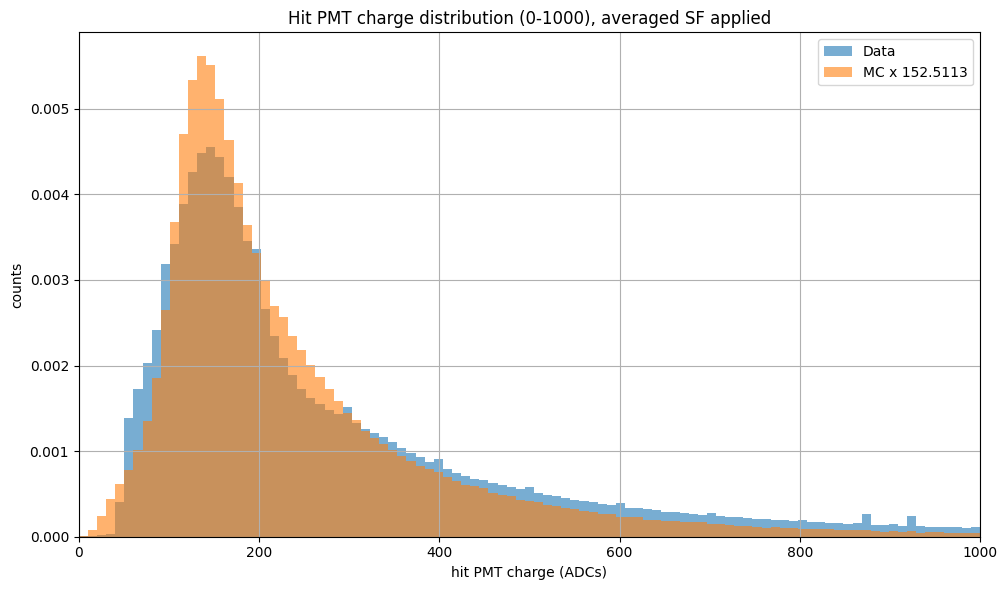

In [ ]:
data_charges = ak.flatten(data["hit_pmt_charges"])
mc_charges = ak.flatten(mc["hit_pmt_charges"]) * average_scale_factor  #scale factor

min_range_charge = 0
max_range_charge = 1000

data_charges = data_charges[(data_charges >= min_range_charge) & (data_charges <= max_range_charge)]
mc_charges = mc_charges[(mc_charges >= min_range_charge) & (mc_charges <= max_range_charge)]

bins = np.linspace(min_range_charge, max_range_charge, 100)

plt.figure(figsize=(10, 6))
plt.hist(data_charges, bins=bins, alpha=0.6, label=f'Data', histtype='stepfilled', density=True)
plt.hist(mc_charges, bins=bins, alpha=0.6, label=f'MC x {average_scale_factor:.4f}', histtype='stepfilled', density=True)

plt.xlabel('hit PMT charge (ADCs)')
plt.ylabel('counts')
plt.title('Hit PMT charge distribution (0-1000), averaged SF applied')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(min_range_charge, max_range_charge)

plt.show()

# now calculate the scale factor per slot id and plot it

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# --- Matplotlib formatting ---
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [11, 8]
rcParams['font.size'] = 22
rcParams['axes.labelsize'] = 20
rcParams['axes.titlesize'] = 20
rcParams['legend.fontsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16

# --- Compute per-PMT indices ---
data_idx = 19 * data_slot_ids + data_channel_ids
mc_idx   = 19 * mc_slot_ids + mc_channel_ids

# --- Normalize by mu_spe per PMT ---
data_charges_pe = data_charges / mu_spe[data_idx]
mc_charges_pe   = mc_charges / mu_spe[mc_idx]

# --- Remove NaNs (if some PMTs have missing mu_spe) ---
data_charges_pe = data_charges_pe[~np.isnan(data_charges_pe)]
mc_charges_pe   = mc_charges_pe[~np.isnan(mc_charges_pe)]

# --- Limit histogram range ---
min_range_charge = 0
max_range_charge = 15
data_charges_pe = data_charges_pe[(data_charges_pe >= min_range_charge) &
                                  (data_charges_pe <= max_range_charge)]
mc_charges_pe   = mc_charges_pe[(mc_charges_pe >= min_range_charge) &
                                (mc_charges_pe <= max_range_charge)]

# --- Histogram bins ---
lo = min(np.min(data_charges_pe), np.min(mc_charges_pe), min_range_charge)
hi = max_range_charge
bins = np.linspace(lo, hi, 100)

# --- Histogram counts ---
data_counts, _ = np.histogram(data_charges_pe, bins=bins)
mc_counts, _   = np.histogram(mc_charges_pe, bins=bins, weights=mc_weights)
mc_w2, _       = np.histogram(mc_charges_pe, bins=bins, weights=mc_weights**2)

# Only bins with entries
valid = (mc_counts > 0) & (data_counts > 0)

# --- Ratio and propagated error ---
ratio = np.full_like(mc_counts, np.nan, dtype=float)
ratio[valid] = data_counts[valid] / mc_counts[valid]

data_err = np.sqrt(data_counts.astype(float))
mc_err   = np.sqrt(mc_w2)
ratio_err = np.full_like(ratio, np.nan, dtype=float)
ratio_err[valid] = ratio[valid] * np.sqrt((data_err[valid]/data_counts[valid])**2 +
                                          (mc_err[valid]/mc_counts[valid])**2)

bin_centers = 0.5*(bins[:-1] + bins[1:])

# --- Plot ---
fig = plt.figure(figsize=(11, 8), dpi=180)
gs = plt.GridSpec(2,1, height_ratios=[3,1], hspace=0.05)

# Top: Data vs MC histogram
ax = plt.subplot(gs[0])
ax.hist(data_charges_pe, bins=bins, alpha=0.5, color='magenta',
        label=f'Data [P.E. normalized]: {len(data_charges_pe)} mu- events',
        histtype='stepfilled', density=True, edgecolor='purple')
ax.hist(mc_charges_pe, bins=bins, alpha=0.5, color='lightgreen',
        label='MC [P.E. normalized]', weights=mc_weights,
        histtype='stepfilled', density=True, edgecolor='green')
ax.set_ylabel('counts')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(lo, hi)
ax.set_ylim(0, 0.9)
ax.set_yticks(np.arange(0, 0.9+0.1, 0.1))
ax.set_title('Hit PMT charge for muon-only - normalized by PMT μ_SPE')

# Bottom: Ratio plot
axr = plt.subplot(gs[1], sharex=ax)
axr.errorbar(bin_centers[valid], ratio[valid], yerr=ratio_err[valid],
             fmt='o', ms=4, color='black', ecolor='gray', capsize=2)
axr.axhline(1.0, color='red', linestyle='--', label="ratio = 1.0")
axr.set_ylim(0, 3)
axr.set_yticks([0, 1, 2, 3])
axr.legend()
axr.set_xlabel('Hit PMT charge / μ_SPE')
axr.set_ylabel('Data / MC')
axr.grid(True, alpha=0.3)

plt.setp(ax.get_xticklabels(), visible=False)  # hide top x-axis labels
plt.tight_layout()
plt.show()

NameError: name 'mu_spe' is not defined